In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import expon
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

import matplotlib.pyplot as plt

 
%matplotlib inline

Read csv and create figure size for notebook

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename columns for easier input

In [3]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'}, inplace = True)

Replacing incompatible timestamps

In [4]:
ufo['datetime'] = ufo['datetime'].apply(lambda x: x + ':00')

In [75]:
{"tags": [
        "remove_input",
    ]}
ufo.datetime.replace('24:00:00', '00:00:00')


0       1949-10-10 20:30:00
1       1949-10-10 21:00:00
2       1955-10-10 17:00:00
3       1956-10-10 21:00:00
4       1960-10-10 20:00:00
5       1961-10-10 19:00:00
6       1965-10-10 21:00:00
7       1965-10-10 23:45:00
8       1966-10-10 20:00:00
9       1966-10-10 21:00:00
10      1968-10-10 13:00:00
11      1968-10-10 19:00:00
12      1970-10-10 16:00:00
13      1970-10-10 19:00:00
14      1971-10-10 21:00:00
15      1972-10-10 19:00:00
16      1972-10-10 22:30:00
17      1973-10-10 19:00:00
18      1973-10-10 23:00:00
19      1974-10-10 19:30:00
20      1974-10-10 21:30:00
21      1974-10-10 23:00:00
22      1975-10-10 17:00:00
23      1976-10-10 20:30:00
24      1976-10-10 22:00:00
25      1977-10-10 12:00:00
26      1977-10-10 22:00:00
27      1978-10-10 02:00:00
28      1979-10-10 00:00:00
29      1979-10-10 22:00:00
                ...        
80302   2012-09-09 20:00:00
80303   2012-09-09 20:10:00
80304   2012-09-09 20:30:00
80305   2012-09-09 20:30:00
80306   2012-09-09 2

Seperating date from time

In [6]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-8])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[-4:])
ufo['year'] = ufo['year'].str.split('/')
ufo['time'] = ufo['datetime'].map(lambda x: str(x)[-8:])


Convert datetime by adding date and time seperately

In [7]:
ufo['datetime'] = pd.to_datetime(ufo.date) + pd.to_timedelta(ufo.time)

Change year column to be the year of datetime which is an integer

In [8]:
ufo['year'] = ufo['datetime'].dt.year

In [9]:
print(ufo.datetime.dtypes)

datetime64[ns]


change latitude from an object to a float

In [10]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


Strip whitespace in longitude header

In [11]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

Creating new Data Frames. One starting at the lower whisker of the boxplot of the total sighting. Other starting after.

In [44]:
#Making two new data frames
ufo['year'] = ufo['year'].astype(int)
ufo_b4_1993 = ufo[ufo['year'] < 1993]
ufo_after_1993 = ufo[(ufo['year'] >= 1993) & (ufo['year'] <= 2013)]

Changing the duration in seconds to a float

In [13]:
ufo['duration_seconds'] = pd.to_numeric(ufo.duration_seconds, errors = 'coerce')
print(ufo['duration_seconds'].dtypes)
print(ufo.duration_seconds.describe())

float64
count    8.032900e+04
mean     9.017226e+03
std      6.202284e+05
min      1.000000e-03
25%      3.000000e+01
50%      1.800000e+02
75%      6.000000e+02
max      9.783600e+07
Name: duration_seconds, dtype: float64


In [14]:
print(ufo.dtypes)

datetime            datetime64[ns]
city                        object
state                       object
country                     object
shape                       object
duration_seconds           float64
duration_hrs_min            object
comments                    object
date_posted                 object
latitude                   float64
longitude                  float64
date                        object
year                         int64
time                        object
dtype: object


In [15]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

#print(states.values())

In [16]:
ufo['state'] = ufo.state.str.upper()
state_seen = ufo.groupby('state').state.agg(['count'])
ufo_states = ufo['state'].replace(lambda x: states.values())

#print(state_seen)
#print(ufo_states)

In [17]:
#top ten shapes
light = ufo.loc[ufo['shape'] == 'light']
triangle = ufo.loc[ufo['shape'] == 'triangle']
circle = ufo.loc[ufo['shape'] == 'circle']
formation = ufo.loc[ufo['shape'] == 'formation']
oval = ufo.loc[ufo['shape'] == 'oval']
disk = ufo.loc[ufo['shape'] == 'disk']
sphere = ufo.loc[ufo['shape'] == 'sphere']
unknown = ufo.loc[ufo['shape'] == 'unknown']
other = ufo.loc[ufo['shape'] == 'other']
fireball = ufo.loc[ufo['shape'] == 'fireball']


/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


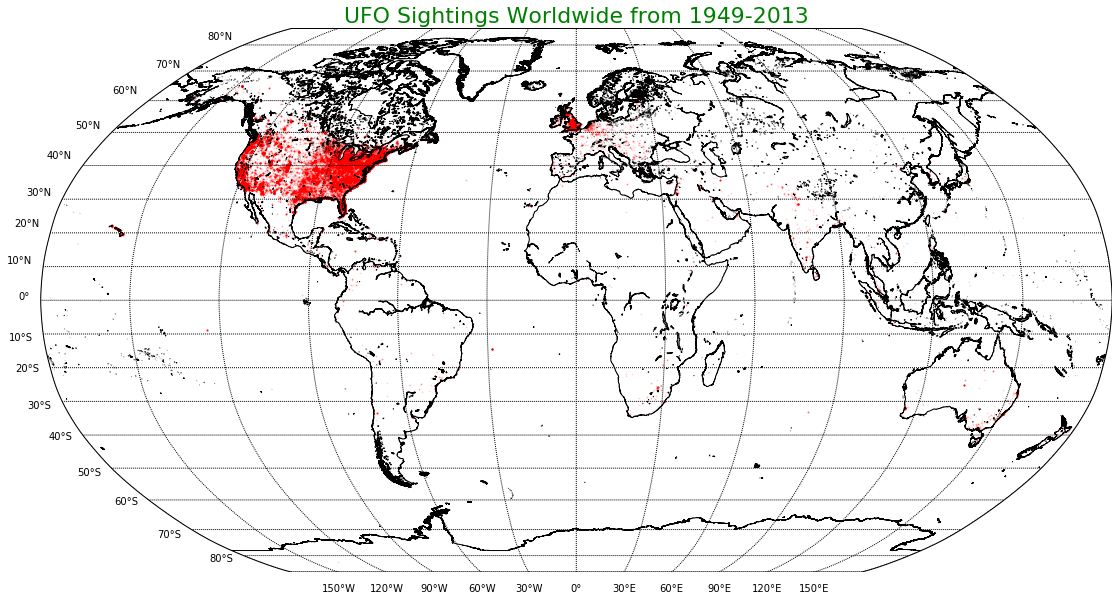

In [18]:
m = Basemap(projection='robin',lon_0=0,resolution='f')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red', alpha = .1)
plt.title('UFO Sightings Worldwide from 1949-2013', fontsize = 22, color = 'green')
plt.show()

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


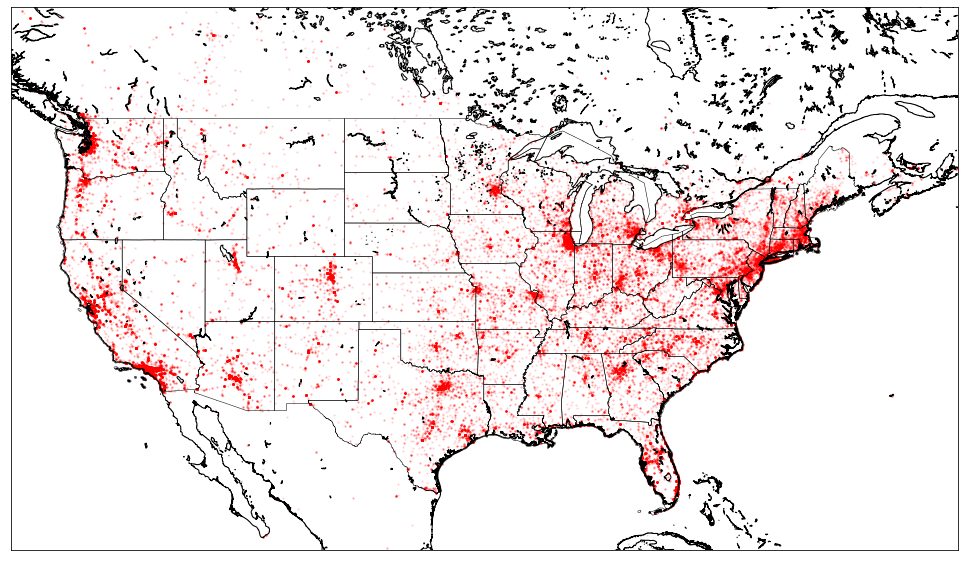

In [19]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'f')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red', alpha = .1)


/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


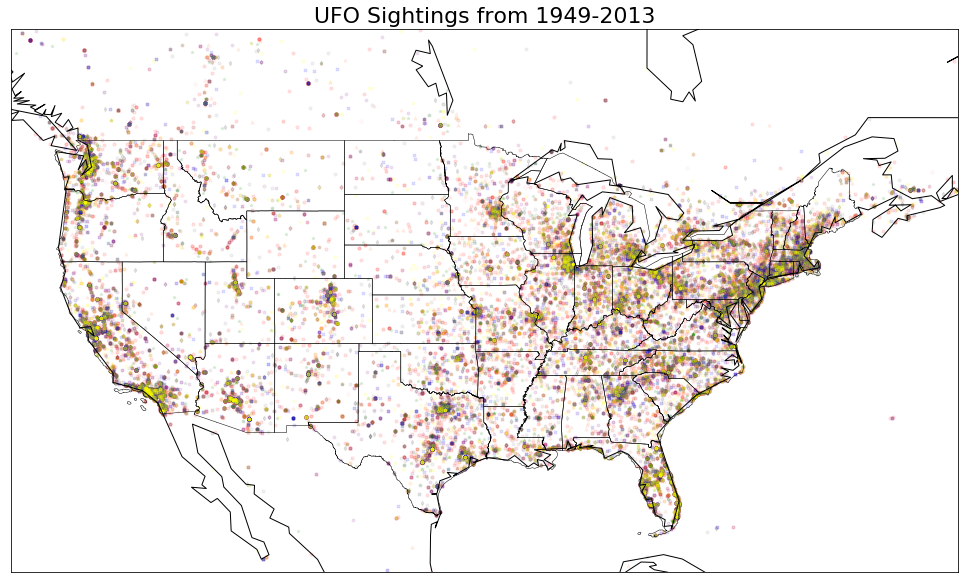

In [34]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawcoastlines()



m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 10, c = 'red', alpha = .1)
m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 10, c = 'coral', marker = '^', alpha = .1)
m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 10, c = 'grey', marker = 'o', alpha = .1)
m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 10, c = 'pink', marker = 'D', alpha = .1)
m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 10, c = 'black', marker = 'd', alpha = .1)
m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 10, c = 'purple', marker = 'h', alpha = .1)
m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 10, c = 'yellow', marker = '8', alpha = .1)
m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 10, c = 'green', marker = '*', alpha = .1)
m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 10, c = 'blue', marker = 'X', alpha = .1)
m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 10, c = 'yellow', marker = 'p', alpha = .1)

States with most UFOs seen

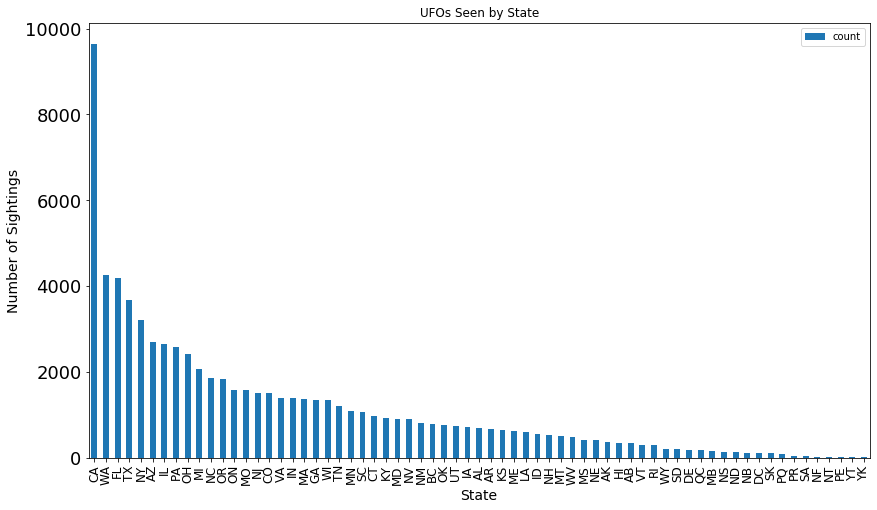

In [21]:
ax = state_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by State', fontsize = 18)
ax.set_xlabel('State', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 12)

In [22]:
state_count = ufo.state.value_counts()
state_count_pct = ufo.state.value_counts(normalize = True)
print(state_count.head())
print(state_count_pct.head())
west_coast = ufo.loc[(ufo['state'] == 'CA') & (ufo['state'] == 'WA') & (ufo['state'] == 'OR')]
rest_country = ufo.loc[(ufo['state'] != 'NY') & (ufo['state'] != 'WA') & (ufo['state'] != 'OR')]

#ax = sns.barplot(west_coast)

CA    9655
WA    4268
FL    4200
TX    3677
NY    3219
Name: state, dtype: int64
CA    0.129536
WA    0.057262
FL    0.056349
TX    0.049333
NY    0.043188
Name: state, dtype: float64


Plot a histogram of number of ufos seen by year

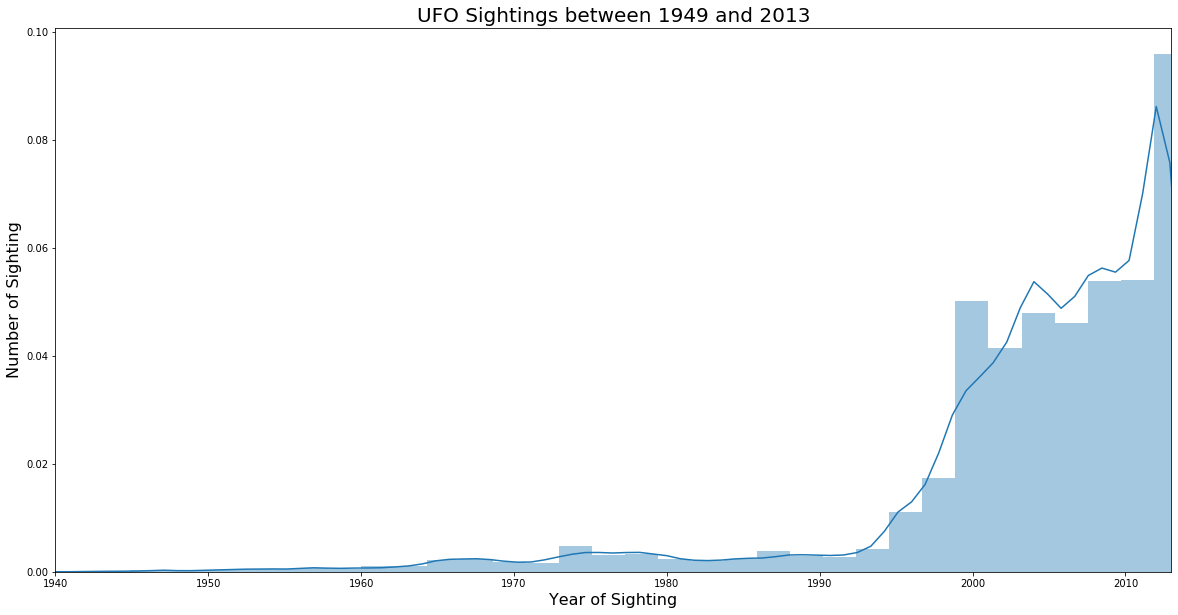

In [23]:
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.distplot(ufo['year'])
#ax = sns.barplot(ufo_total.groupby('year').value_counts())
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO Sightings between 1949 and 2013', fontsize = 20)
ax.set_xlim(1940, 2013)

plt.show()

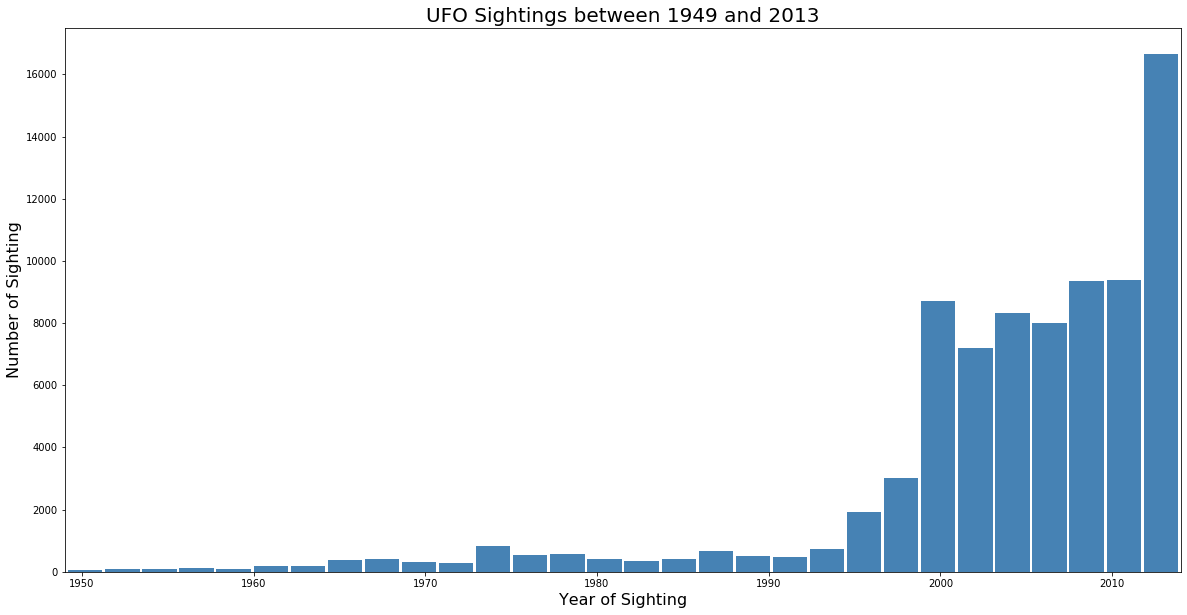

In [85]:
fig, ax = plt.subplots()
ax.hist(ufo['year'], bins = 50, color = 'steelblue', width = 2)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO Sightings between 1949 and 2013', fontsize = 20)
ax.set_xlim(1949, 2014)

data_expon = expon.rvs(scale=1,loc=0,size=1000)

(1949, 1992)

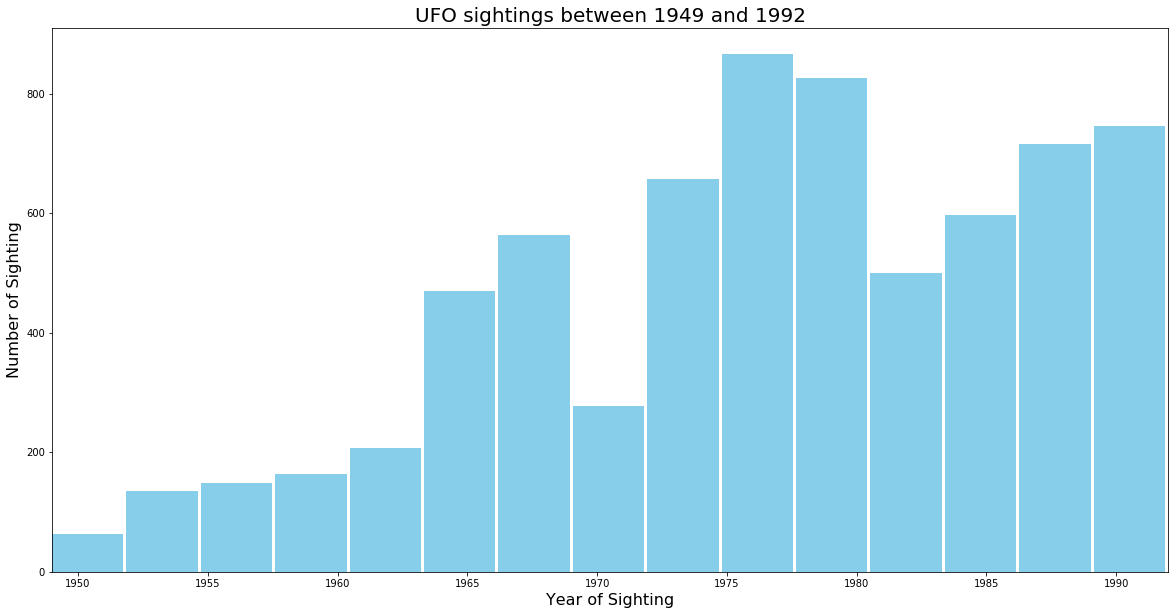

In [73]:
ax = plt.subplot()
ax.hist(ufo_b4_1993['year'], bins = 30, color = 'skyblue', width = 2.75)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO sightings between 1949 and 1992', fontsize = 20)

ax.set_xlim(1949, 1992)


(1949, 1993)

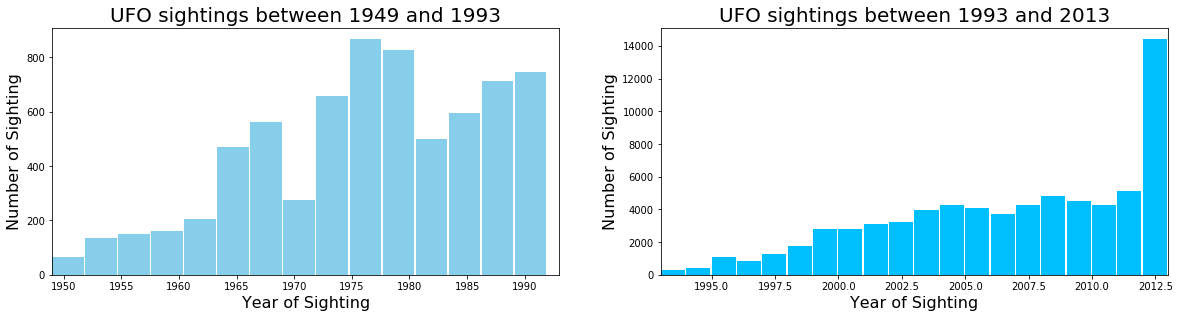

In [82]:
ax = plt.subplot(222)
ax.hist(ufo_after_1993['year'], bins = 20, color = 'deepskyblue', width = .95)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO sightings between 1993 and 2013', fontsize = 20)
ax.set_xlim(1993, 2013)

ax1 = plt.subplot(221)
ax1.hist(ufo_b4_1993['year'], bins = 30, color = 'skyblue', width = 2.75)
ax1.set_xlabel('Year of Sighting', fontsize = 16)
ax1.set_ylabel('Number of Sighting', fontsize = 16)
ax1.set_title('UFO sightings between 1949 and 1993', fontsize = 20)
ax1.set_xlim(1949, 1993)

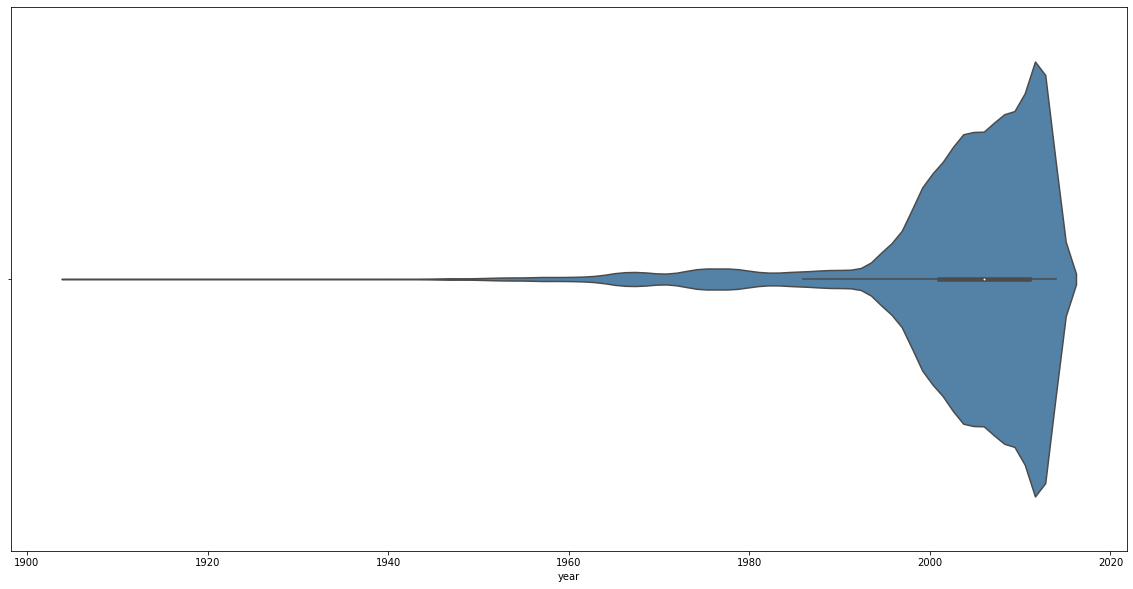

In [66]:
sns.violinplot(ufo['year'], color = 'steelblue')

count    80332.000000
mean      2003.850110
std         10.426848
min       1906.000000
25%       2001.000000
50%       2006.000000
75%       2011.000000
max       2014.000000
Name: year, dtype: float64


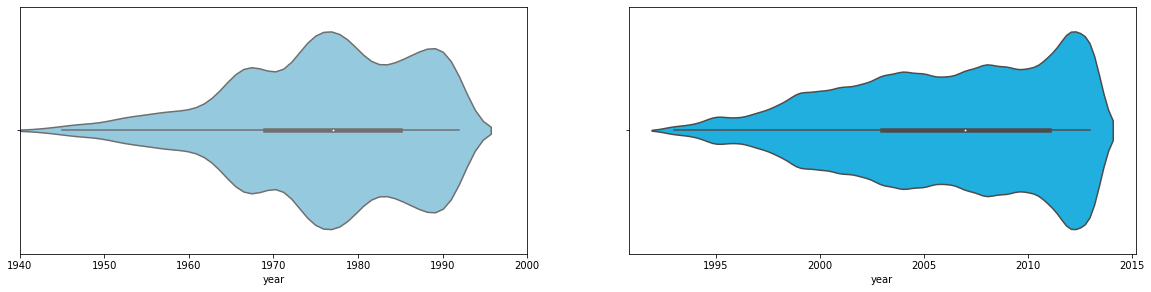

In [69]:

ax2 = plt.subplot(223)
sns.violinplot(ufo_b4_1993['year'], color = 'skyblue')
ax2.set_xlim(1940, 2000)
ax3 = plt.subplot(224)
sns.violinplot(ufo_after_1993['year'], color = 'deepskyblue')




print(ufo['year'].describe())


Text(0, 0.5, 'Number of Sightings')

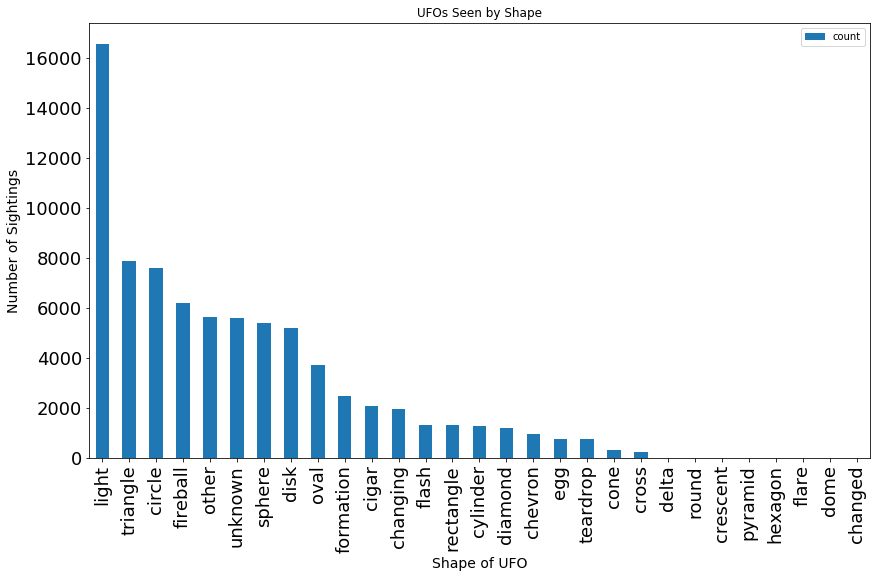

In [46]:
ax = shapes_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by Shape', fontsize = 18)
ax.set_xlabel('Shape of UFO', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)




In [38]:
shapes_seen = ufo.groupby('shape').shape.agg(['count'])

In [36]:
std_year = np.std(ufo['year'])
describe_year = ufo['year'].describe()
mean_year = np.mean(ufo['year'])
median_year = np.median(ufo['year'])

print(describe_year)

count    80332.000000
mean      2003.850110
std         10.426848
min       1906.000000
25%       2001.000000
50%       2006.000000
75%       2011.000000
max       2014.000000
Name: year, dtype: float64


New dataframe with only year, shape, and state seen

In [37]:
#year_by_shape = ufo.groupby(['year', 'state', 'shape']).size().unstack().reset_index()

#print(year_by_shape.head())

Finding different shapes seen and their counts

In [ ]:
#print(shapes_seen)
print(shapes_seen.dtypes)


Barplot of shapes seen in descending order

Sighting duration in seconds

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


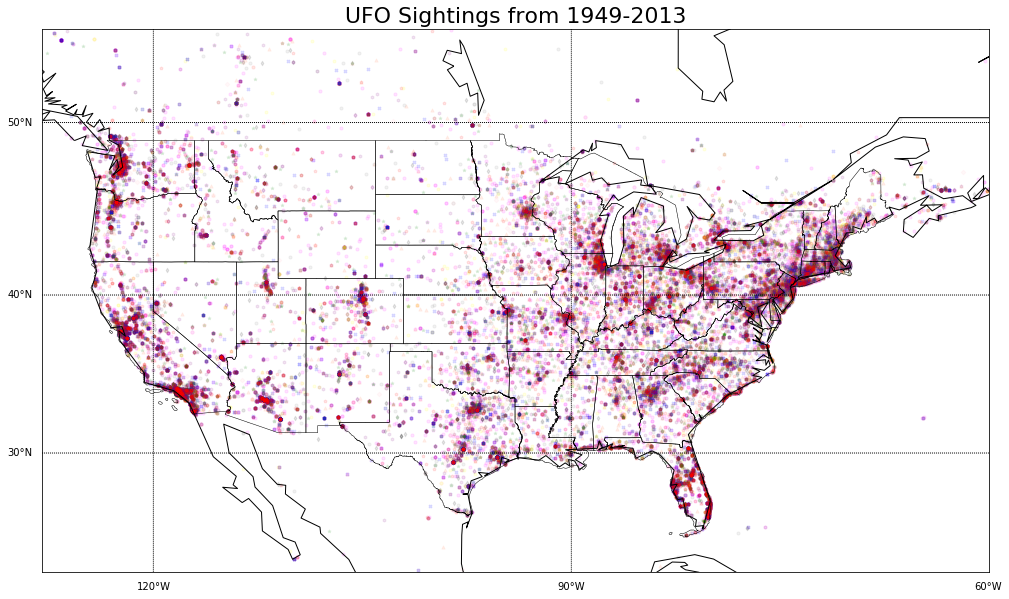

In [39]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 10, c = 'magenta', alpha = .1)
m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 10, c = 'coral', marker = '^', alpha = .1)
m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 10, c = 'grey', marker = 'o', alpha = .1)
m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 10, c = 'pink', marker = 'D', alpha = .1)
m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 10, c = 'black', marker = 'd', alpha = .1)
m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 10, c = 'purple', marker = 'h', alpha = .1)
m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 10, c = 'yellow', marker = '8', alpha = .1)
m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 10, c = 'green', marker = '*', alpha = .1)
m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 10, c = 'blue', marker = 'X', alpha = .1)
m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 10, c = 'red', marker = 'p', alpha = .1)

In [40]:
california = ufo.loc[ufo['state'] == 'CA']

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


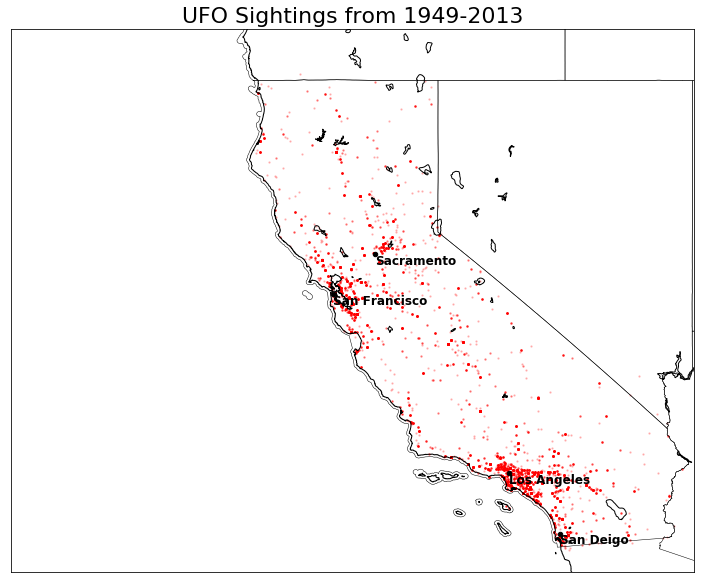

In [55]:
m = Basemap(projection = 'mill',
           llcrnrlat = 32,
           urcrnrlat = 43,
           llcrnrlon = -130,
           urcrnrlon = -114,
           resolution = 'f')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawcoastlines()

m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'counties')
#m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 2, c = 'magenta', alpha = .5)
#m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 2, c = 'coral', marker = '^', alpha = .5)
#m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 2, c = 'grey', marker = 'o', alpha = .5)
#m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 2, c = 'pink', marker = 'D', alpha = .5)
#m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 2, c = 'black', marker = 'd', alpha = .5)
#m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 2, c = 'purple', marker = 'h', alpha = .5)
#m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 2, c = 'yellow', marker = '8', alpha = .5)
#m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 2, c = 'green', marker = '*', alpha = .5)
#m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 2, c = 'blue', marker = 'X', alpha = .5)
#m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 2, c = 'red', marker = 'p', alpha = .5)
m.scatter(california.longitude.to_list(), california.latitude.to_list(), latlon = True, s = 2, c = 'red', alpha = .2)
m.scatter([-121.47, -122.45, -118.33, -117.15], [38.56, 37.75, 34.08, 32.81], latlon = True, s = 20, alpha = 1, c = 'black')

sclon = -121.47
sclat = 38.56
x, y = m(sclon, sclat)  
plt.text(x, y, 'Sacramento',fontsize=12,fontweight='bold', ha='left',va='top',color='k')

sflon = -122.45
sflat = 37.75
x, y = m(sflon, sflat)
plt.text(x, y, 'San Francisco',fontsize=12,fontweight='bold', ha='left',va='top',color='k')

lalon = -118.33
lalat = 34.08
x, y = m(lalon, lalat)
plt.text(x, y, 'Los Angeles',fontsize=12,fontweight='bold', ha='left',va='top',color='k')

sdlon = -117.15
sdlat = 32.81
x, y = m(sdlon, sdlat)
plt.text(x, y, 'San Deigo',fontsize=12,fontweight='bold', ha='left',va='top',color='k')



city_lons = [-121.47, -122.45, -118.33, -117.15]
city_lats = [38.56, 37.75, 34.08, 32.81]

In [42]:
median_sighting = Point(38.1244768246185, -86.7728845471172)

In [43]:
ttest_ind(ufo_b4_1993['year'], ufo_after_1993['year'], equal_var = False)

Ttest_indResult(statistic=-241.31191152199418, pvalue=0.0)